### 2월 8일

유효한 좌표
유효한 좌표
최소 비용 wp from start : 0번, 비용 : 179.0
두 번째로 작은 비용 wp from start : 23번, 비용 : 190.0
min1 선택! (start)
최소 비용 wp from goal : 17번, 비용 : 38.0
최소 비용 wp from goal : 20번, 비용 : 50.0
min1 선택 (goal)
new_start = (110, 237), new_goal = (73, 158)
waypoint 기반 전역 경로 pathplanning
처음 wp_path = [(110, 237), (142, 276), (187, 196), (155, 158), (73, 158)]
no
최단 경로: [(110, 237), (142, 276), (187, 196), (155, 158), (73, 158), (66, 127)]
--------------------------------------------------
최종 wp_path = [(110, 237), (142, 276), (187, 196), (155, 158), (73, 158), (66, 127)]
맨 처음 조건문
min1_take = 1
맨 앞에 start 삽입
최종 wp_path = [(86, 217), (110, 237), (142, 276), (187, 196), (155, 158), (73, 158), (66, 127)]
샘플링하기 전 real_path 갯수 = 47
1 번째 경로의 start : [217  86], goal : [237 110], wp_goal : (110, 237)
현재 두 wp 사이 지점 = [[217  86]
 [228  88]
 [229 102]
 [237 110]], 갯수 = 4
현재 구간 real_path 갯수 4, x_path 갯수 4
--------------------------------------------------
마지막 조건문
샘플링하기 전 real_path 갯수 = 72
2 번째 경로의 start : [237 1

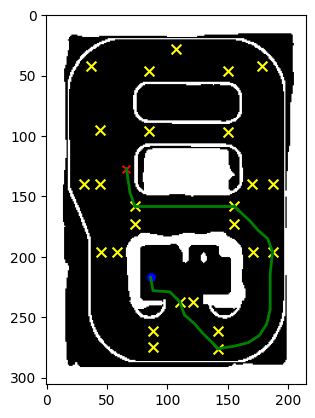

In [ ]:
import heapq
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev

# 맵에서 상하좌우로 이동할 수 있는 방향을 나타내는 리스트
MOVES = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# pgm 지도를 이진화 형태로 변환
def pixel_based_map(img):
    img_height, img_width = img.shape  # 이미지 크기 가져오기

    # 결과 저장할 2D 리스트 생성 (기본값: 1 = 벽)
    map_cost = np.ones((img_height, img_width), dtype=int)

    # 모든 픽셀을 하나씩 순회하면서 계산
    for i in range(img_height):
        for j in range(img_width):
            if img[i, j] > 210:  # 밝은 픽셀(도로)
                map_cost[i, j] = 0  # 도로(0)
            else:  # 어두운 픽셀(벽)
                map_cost[i, j] = 1  # 벽(1)

    return map_cost

# 가장 적은 비용을 가진 두 wp 가져오기
def find_two_smallest(cost_list):
    min1, min2 = float('inf'), float('inf')  # 처음에는 무한대로 초기화

    for value in cost_list:
        if value < min1:
            min2 = min1  # 현재 min1이 두 번째로 작은 값이 됨
            min1 = value  # 새로운 최소값을 min1에 할당
        elif value < min2:  # min1보다 크고 min2보다 작은 값
            min2 = value  # 두 번째로 작은 값 업데이트

    return min1, min2, cost_list.index(min1), cost_list.index(min2)


# 장애물 근처에 가중치 맵 생성하기
def create_weight_map(grid, middle, buffer_size, penalty):
    background = grid  # 이진화 된 배열 형태의 전체 map
    overlay = middle  # 이진화 된 배열 형태의 중앙선 map

    background[200:228, 86:89] = 1

    x, y = 18, 19  # 중앙선 map 을 삽입할 위치

    background_result = background.astype('uint8')
    overlay = overlay.astype('uint8')

    h, w = overlay.shape[:2]
    background_roi = background_result[y:y+h, x:x+w]

    result_roi = background_roi - overlay

    background_result[y:y+h, x:x+w] = result_roi

    # plt.imshow(background_result, cmap='gray')
 
    obstacle = background_result == 1
    # 장애물 주변에 가중치를 부여
    dilated_obstacle = binary_dilation(obstacle, structure=np.ones((buffer_size, buffer_size)))
    weight_map = np.zeros_like(background_result, dtype=float)
    weight_map[dilated_obstacle] = penalty
    return weight_map, background_result

# 휴리스틱 함수 : 유클리드 거리 계산
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
    # return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def a_star(start, goal, waypoint_graph=None, grid=None, weight_map=None):
    # waypoint 기반 전역 경로 pathplanning
    if grid is None and weight_map is None:
        print('waypoint 기반 전역 경로 pathplanning')
        """ A* 알고리즘을 사용하여 start에서 goal까지 최단 경로 찾기 """
        open_set = []  # 우선순위 큐 (힙)
        heapq.heappush(open_set, (0, start))  # (f_score, node)
        
        came_from = {}  # 경로 추적을 위한 딕셔너리
        g_score = {node: float('inf') for node in waypoint_graph}  # 시작점에서의 거리
        g_score[start] = 0
        f_score = {node: float('inf') for node in waypoint_graph}  # 휴리스틱 거리 포함 점수
        f_score[start] = euclidean_distance(start, goal)
        
        while open_set:
            _, current = heapq.heappop(open_set)  # f_score가 가장 낮은 노드 선택
            
            if current == goal:
                # 최단 경로를 재구성하여 반환
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                return path[::-1]  # 역순으로 반환
            
            for neighbor in waypoint_graph[current]:
                tentative_g_score = g_score[current] + euclidean_distance(current, neighbor)
                
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + euclidean_distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        
        return None  # 경로가 없는 경우
    # 두 waypoint 사이 pathplanning
    else:
        open_set = []
        heapq.heappush(open_set, (0 + euclidean_distance(start, goal), 0, start))
        g_costs = {start: 0}

        came_from = {}

        while open_set:
            _, current_cost, current = heapq.heappop(open_set)

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()

                # goal까지의 총 비용 출력
                # print(f"Total cost from {start} to {goal}: {g_costs[goal]}")
                return path, g_costs[goal]
            
            for move in MOVES:
                neighbor = (current[0] + move[0], current[1] + move[1])
                if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                    tentative_g_cost = current_cost + 1 + weight_map[neighbor]  # 가중치 추가
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + euclidean_distance(neighbor, goal)
                        # f_cost = tentative_g_cost + manhattan_distance(neighbor, goal)
                        heapq.heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        came_from[neighbor] = current
        return None
    
def valid_start_goal(coord):
    if (20 < coord[0] < 73) and (133 < coord[1] < 195):
        print('호출 및 주정차 금지 구역 입니다.')
        return False
    else:
        print('유효한 좌표')
        return True

def find_start_goal(coord, waypoint_graph, flag=None):
        global min1_take, min2_take, one_way, exc_sig
        cost_list = []
        for station in waypoint_graph:
            _, g_cost = a_star((coord[1], coord[0]), (station[1], station[0]), waypoint_graph, grid, weight_map)
            cost_list.append(g_cost)
        
        min1, min2, min1_idx, min2_idx = find_two_smallest(cost_list)

        # start 좌표를 줬을 때
        if flag is None:
            if (88 < start[1] < 107 and 85 < start[0] < 150):  # 일방 통행 구역에 start 가 있으면
                print('start 가 일방통행 구역 안에 있으므로 따로 처리')
                new_coord = wp_num[22]
                one_way = 1
                return new_coord
            elif (37 < start[1] < 56 and 85 < start[0] < 150):  # 다른 일방 통행 구역에 start 가 있으면
                print('start 가 일방통행 구역 안에 있으므로 따로 처리')
                new_coord = wp_num[25]
                one_way = 1
                return new_coord
            else:
                print(f"최소 비용 wp from start : {min1_idx}번, 비용 : {min1}")
                print(f"두 번째로 작은 비용 wp from start : {min2_idx}번, 비용 : {min2}")

                # if (min1_idx == 20 and min2_idx == 21 and start[1] < 90) or (min1_idx == 5 and min2_idx == 20):
                if (min1_idx == 20 and min2_idx == 21 and start[1] < 90):   
                    new_coord, idx = wp_num[min2_idx], min2_idx
                    min2_take = 1
                    print('min2 선택!(start)')
                    return new_coord
                else:
                    # new_coord, idx = wp_num[min1_idx], min1_idx
                    # min1_take = 1
                    # print('min1 선택! (start)')
                    # if (min1_idx == 20 and min2_idx == 5) or (min1_idx == 5 and min2_idx == 20) or (min1_idx == 5 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 5):
                    if (min1_idx == 20 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 20) or (min1_idx == 5 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 5):
                        exc_sig = 1
                        new_coord = wp_num[20]
                        print('5번, 20번 예외처리')
                        return new_coord
                    else:
                        new_coord, idx = wp_num[min1_idx], min1_idx
                        min1_take = 1
                        print('min1 선택! (start)')
                        return new_coord
        
        # goal 좌표를 줬을 때
        else:
            print(f"최소 비용 wp from goal : {min1_idx}번, 비용 : {min1}")
            print(f"최소 비용 wp from goal : {min2_idx}번, 비용 : {min2}")

            if min1_idx == 5 and min2_idx == 20:
                new_coord, idx = wp_num[min2_idx], min2_idx
                print('min2 선택 (goal)')
                return new_coord
            else:
                new_coord, idx = wp_num[min1_idx], min1_idx
                print('min1 선택 (goal)')
                return new_coord
            
def expand_coordinates(coord, buffer_size):
    x, y = coord
    expanded_area = [(x + dx, y + dy) 
                     for dx in range(-buffer_size, buffer_size + 1) 
                     for dy in range(-buffer_size, buffer_size + 1)]
    return expanded_area

def expand_multiple_coordinates(coord_list, buffer_size):
    expanded_set = set()  # 중복 제거를 위해 set 사용
    for coord in coord_list:
        expanded_set.update(expand_coordinates(coord, buffer_size))
    return list(expanded_set)

# wp number
wp_num = {
    0 : (110, 237),
    1 : (88, 261),
    2 : (88, 275),
    3 : (58, 196),
    4 : (45, 196),
    5 : (44, 140),
    6 : (31, 140),
    7 : (37, 42),
    8 : (107, 28),
    9 : (178, 42),
    10 : (187, 140),
    11 : (170, 140),
    12 : (187, 196),
    13 : (171, 196),
    14 : (142, 276),
    15 : (142, 261),
    16 : (73, 173),
    17 : (73, 158),
    18 : (155, 173),
    19 : (155, 158),
    20 : (85,96),
    21 : (85, 46),
    22 : (150, 97),
    23 : (121, 237),
    24 : (44,95),
    25 : (150, 46),
    # 일방 통행 좌표용
    30 : (88, 107),
    31 : (37, 56)
}

# Waypoint 그래프
waypoint_graph = {
    wp_num[0]: [wp_num[1], wp_num[14]],  # 0번 : 1, 14
    wp_num[1]: [wp_num[3]],  # 1번 : 3
    wp_num[2]: [wp_num[14], wp_num[23]],  # 2번 : 14, 23
    wp_num[3]: [wp_num[16], wp_num[20], wp_num[21]],  # 3번 : 16, 20
    wp_num[4]: [wp_num[2]],  # 4번 : 2
    wp_num[5]: [wp_num[16]],  # 5번 : 16
    wp_num[6]: [wp_num[4]],  # 6번 : 4
    wp_num[7]: [wp_num[6], wp_num[24]],  # 7번 : 6, 24
    wp_num[8]: [wp_num[7]],  # 8번 : 7
    wp_num[9]: [wp_num[8]],  # 9번 : 8
    wp_num[10]: [wp_num[9]],  # 10번 : 9
    wp_num[11]: [wp_num[13], wp_num[19]],  # 11번 : 13, 19
    wp_num[12]: [wp_num[10], wp_num[19]],  # 12번 : 10, 19
    wp_num[13]: [wp_num[15]],  # 13번 : 15
    wp_num[14]: [wp_num[12]],  # 14번 : 12
    wp_num[15]: [wp_num[1], wp_num[23]],  # 15번 : 1, 23
    wp_num[16]: [wp_num[18]],  # 16번 : 18
    wp_num[17]: [wp_num[4], wp_num[20], wp_num[21]],  # 17번 : 4, 20, 21
    wp_num[18]: [wp_num[10], wp_num[13]],  # 18번 : 10, 13
    wp_num[19]: [wp_num[17]],  # 19번 : 17
    wp_num[20]: [wp_num[21], wp_num[22]],  # 20번 : 21, 22
    # wp_num[20]: [wp_num[22]],  # 20번 : 21, 22
    wp_num[21]: [wp_num[25]],  # 21번 : 25
    wp_num[22]: [wp_num[11]],  # 22번 : 11

    wp_num[23]: [],  # 23번 : 도착 시 행하는 명령어만 따로 만들기

    wp_num[24]: [wp_num[5], wp_num[6]],  # 24번 : 5, 6  
    wp_num[25]: [wp_num[11]]  # 25번 : 11
}

# 주 지도
map = cv2.imread('/home/yoon/ws/ros-repo-3/src/Server/User_GUI/Images/asap_map_resized.pgm', cv2.COLOR_BGR2GRAY)
# print(f'map.shape = {map.shape}')

# 중앙선 지도 (이미 이진화 됨)
middle = cv2.imread('/home/yoon/ws/open_cv/data/asap_map_middleLine.png', cv2.IMREAD_GRAYSCALE)
# middle = cv2.cvtColor(middle, )
# print(f'middle.shape = {middle.shape}')

# 지도 변환 pgm -> 이진 배열 (0: 도로, 1: 장애물)
grid = pixel_based_map(map)
plt.imshow(grid, cmap='gray')

# Waypoints 시각화
for wp, neighbors in waypoint_graph.items():
    plt.scatter(wp[0], wp[1], color='yellow', marker='x', s=50)  # Waypoint

# 최초 호출, 반납 여부
# GUI 로부터 받아야 하는 신호
call_first = 1
return_sig = None

# min1, min2 선택 여부
min1_take = None
min2_take = None

# 일방 통행 여부
one_way = None

# (5번, 20번), (5번, 17번) wp 사이 예외 처리 시그널
exc_sig = None

# 테스트 실행
start = (86, 217) # 시작 좌표
# start = wp_num[21]  # 목표 좌표
goal = (66, 127)

# 둘 다 True 면 실행되야 함.
start_valid = valid_start_goal(start)
goal_valid = valid_start_goal(goal)

if start_valid and goal_valid:
    # goal = wp_num[22]
    if return_sig:
        goal = wp_num[23]  # 목표 좌표

    # 장애물 주변 가중치 추가
    weight_map, background_result = create_weight_map(grid, middle, buffer_size=10, penalty=7)

        
    # 시작점, 출발점 보간
    new_start = find_start_goal(start, waypoint_graph)
    new_goal = find_start_goal(goal, waypoint_graph, flag=1)

    print(f"new_start = {new_start}, new_goal = {new_goal}")

    # 시작점, 목표점
    plt.scatter(start[0], start[1], color='blue', marker='o', label='Start', s=30)
    plt.scatter(goal[0], goal[1], color='red', marker='x', label='Goal', s=30)

    if (new_start != new_goal or exc_sig):

        wp_path = a_star(new_start, new_goal, waypoint_graph)

        print(f'처음 wp_path = {wp_path}')

        s = wp_path[-2]
        g = wp_path[-1]

        path_result, _ = a_star((s[1], s[0]), (g[1], g[0]), waypoint_graph, grid=grid, weight_map=weight_map)

        expended_list = expand_multiple_coordinates(path_result, buffer_size=3)
        
        if (goal[1], goal[0]) in expended_list:
            print('yes')
            wp_path[-1] = goal
        else:
            print('no')
            wp_path.append(goal)
            
        # if new_goal != goal:
        #     print('wp_path 에 goal 값 넣어주기')
        #     # wp_path.append(goal)
        #     wp_path[-1] = goal

        #     # if len(wp_path) > 1:
        #     #     print('wp_path 에 goal 값 넣어주기')
        #     #     # wp_path.append(goal)
        #     #     wp_path[-1] = goal
        #     # else:
        #     #     wp_path.append(goal)
        #     print(f'중간 편집된 wp_path = {wp_path}')

        print("최단 경로:", wp_path)
        print('-' * 50)

        # 전역 경로 사이 두 waypoint 간의 pathplanning 실행
        if wp_path:
            if len(wp_path) == 1 or one_way:
                print('원래 start 좌표가 wp_path 맨 앞으로 들어옴')
                wp_path.insert(0, start)

            if one_way:
                for_cnt = len(wp_path) - 1
            else:
                for_cnt = len(wp_path)

            print(f'최종 wp_path = {wp_path}')

            real_wp_path = []

            for i in range(for_cnt):
                # start 좌표가 waypoint_graph 에 명시된 좌표가 아니면
                # 우선 현재 좌표에서 모든 wp 까지의 비용을 구한 후 가장 최소 비용을 가지는 wp 를 start 좌표로 고정
                if ((i == 0) and (wp_path[i] != start)):
                    if len(wp_path) == 1:
                        print('wp_path 값이 하나일 때')
                        wp_start = start
                        wp_goal = wp_path[i]
                    else:
                        print('맨 처음 조건문')
                        print(f"min1_take = {min1_take}")
                        # 최초 차고지로부터 호출 시 무조건 start = (89, 216) 부근
                        if call_first:  # 최초 한 번 호출 시
                            if exc_sig:
                                print('5번, 20번 예외처리 시작')
                                wp_path[0] = start
                            else:
                                # wp_path[0] = start
                                print('맨 앞에 start 삽입')
                                wp_path.insert(0, start)

                        elif (min1_take is None and min2_take):
                            print('맨 앞에 new_start 삽입')
                            wp_path.insert(0, new_start)  # 이게 min2_take 일 때
                        # elif (min2_take is None and min1_take == 1) or (call_sig is not None):
                        elif (min2_take is None and min1_take):
                            if exc_sig:
                                wp_path.insert(0, start)
                            else:
                                print('일반적으로 min1_take = 1 일 때 맨 앞에 start 삽입')
                                wp_path[0] = start
            
                        wp_start = start
                        wp_goal = wp_path[i + 1]
                    
                    print(f'최종 wp_path = {wp_path}')
                    
                else:
                    try:
                        print('마지막 조건문')
                        wp_start = wp_path[i]
                        wp_goal = wp_path[i + 1]
                    except:
                        pass

                part_path, _ = (a_star((wp_start[1], wp_start[0]), (wp_goal[1], wp_goal[0]), waypoint_graph, grid=grid, weight_map=weight_map))
                real_path = np.array(part_path)

                print(f'샘플링하기 전 real_path 갯수 = {len(real_path)}')

                sample_cnt = 15
                
                if len(real_path) // sample_cnt >= 1 and len(real_path) > sample_cnt:
                    real_path = real_path[::sample_cnt] 
                else:
                    pass

                # 즉 , 샘플링 하고 나서 1개 이상 나와야 함.
                # 경로 마지막 좌표가 waypoint 좌표가 아니면 waypoint 좌표로 맞춰주기
                if (len(wp_path) != 1) and (tuple(real_path[-1]) != (wp_goal[1], wp_goal[0])):
                    real_path[-1] = (wp_goal[1], wp_goal[0])
                    # real_path.append((wp_goal[1], wp_goal[0]))
                print(f"{i + 1} 번째 경로의 start : {(real_path[0])}, goal : {(real_path[-1])}, wp_goal : {wp_goal}")
                
                real_wp_path.append(real_path[0])
                real_wp_path.append(real_path[-1])

                print(f'현재 두 wp 사이 지점 = {real_path}, 갯수 = {len(real_path)}')
                
                path_x = real_path[:, 0]
                path_y = real_path[:, 1]

                print(f"현재 구간 real_path 갯수 {len(real_path)}, x_path 갯수 {len(path_x)}")

                m = len(path_x)  # 데이터 개수
                k = (5, m - 1)  # 최소한 m > k 조건을 만족하도록 설정

                # b - spline 보간법
                try:
                    tck, u = splprep([path_x, path_y], s=5, k=k)  # s 가 클수록 부드러운 곡선
                    u_fine = np.linspace(0, 1, 300)  # 값이 클수록 세밀한 보간
                    smooth_x, smooth_y = splev(u_fine, tck)

                    plt.plot(smooth_y, smooth_x, 'green', linewidth=2, label='Path')
                except:
                    plt.plot(real_path[:, 1], real_path[:, 0], color='green', linewidth=2, label="Path")    
                print('-' * 50)
            # numpy 배열을 튜플로 변환하여 중복 제거 후 다시 배열로 변환
            # unique_arr = list({tuple(arr) for arr in real_wp_path})
            # real_result = [np.array(arr) for arr in unique_arr]
            # print(real_result)
            # print((unique_arr))
        else:
            print('No path found')
    else:
        print('현재 목적지 근처에 있습니다.')

    # 시그널 초기화
    print('모든 시그널 초기화')
    call_first = return_sig = min1_take = min2_take = one_way = exc_sig = for_cnt = None
else:
    print('호출 및 주정차 금지 구역입니다.')


print(start_valid)
print(goal_valid)

In [101]:
print(wp_path)

[(172, 270), (187, 196), (155, 158), (73, 158)]


[[ 46  85]
 [ 54  67]
 [130  65]]


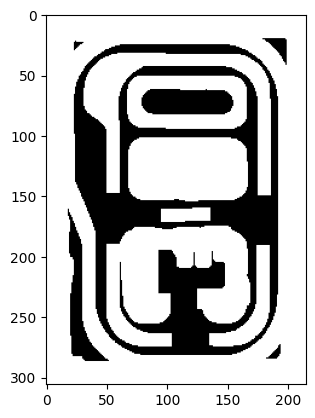

In [77]:
plt.imshow(weight_map, cmap='gray')

In [35]:
def create_weight_map(grid, middle, buffer_size, penalty):
    background = grid  # 이진화 된 배열 형태의 전체 map
    overlay = middle  # 이진화 된 배열 형태의 중앙선 map

    background[200:228, 86:89] = 1

    x, y = 18, 19  # 중앙선 map 을 삽입할 위치

    background_result = background.astype('uint8')
    overlay = overlay.astype('uint8')

    h, w = overlay.shape[:2]
    background_roi = background_result[y:y+h, x:x+w]

    result_roi = background_roi - overlay

    background_result[y:y+h, x:x+w] = result_roi

    # plt.imshow(background_result, cmap='gray')
 
    obstacle = background_result == 1
    # 장애물 주변에 가중치를 부여
    dilated_obstacle = binary_dilation(obstacle, structure=np.ones((buffer_size, buffer_size)))
    weight_map = np.zeros_like(background_result, dtype=float)
    weight_map[dilated_obstacle] = penalty
    return weight_map, background_result

weight_map, background_result = create_weight_map(grid, middle, buffer_size=10, penalty=7)


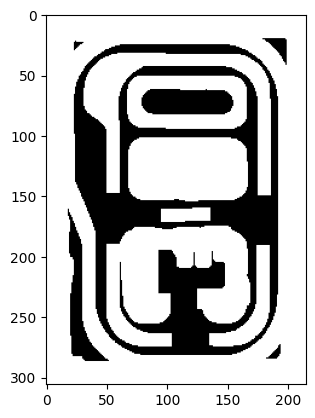

In [36]:
plt.imshow(weight_map, cmap='gray')

### 2월 8일 이후

유효한 좌표
유효한 좌표
최소 비용 wp from start : 17번, 비용 : 28.0
두 번째로 작은 비용 wp from start : 16번, 비용 : 43.0
min1 선택! (start)
최소 비용 wp from goal : 21번, 비용 : 32.0
최소 비용 wp from goal : 25번, 비용 : 37.0
min1 선택 (goal)
new_start = (73, 158), new_goal = (85, 46)
waypoint 기반 전역 경로 pathplanning
처음 wp_path = [(73, 158), (85, 46)]
noooo
최단 경로: [(73, 158), (85, 46), (115, 48)]
--------------------------------------------------
최종 wp_path = [(73, 158), (85, 46), (115, 48)]
맨 처음 조건문
min1_take = 1
일반적으로 min1_take = 1 일 때 맨 앞에 start 삽입
최종 wp_path = [(100, 157), (85, 46), (115, 48)]
샘플링하기 전 real_path 갯수 = 165
1 번째 경로의 start : [157 100], goal : [46 85], wp_goal : (85, 46)
현재 두 wp 사이 지점 = [[157 100]
 [154  88]
 [153  74]
 [144  68]
 [130  67]
 [115  67]
 [100  67]
 [ 85  67]
 [ 71  66]
 [ 57  67]
 [ 46  85]], 갯수 = 11
현재 구간 real_path 갯수 11, x_path 갯수 11
--------------------------------------------------
마지막 조건문
샘플링하기 전 real_path 갯수 = 33
2 번째 경로의 start : [46 85], goal : [ 48 115], wp_goal : (115, 48)
현재 두 wp 사이 지점 = [[ 4

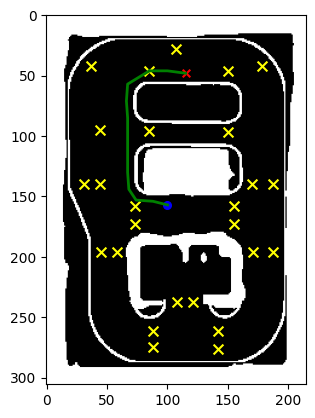

In [ ]:
import heapq
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev

# 맵에서 상하좌우로 이동할 수 있는 방향을 나타내는 리스트
MOVES = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# pgm 지도를 이진화 형태로 변환
def pixel_based_map(img):
    img_height, img_width = img.shape  # 이미지 크기 가져오기

    # 결과 저장할 2D 리스트 생성 (기본값: 1 = 벽)
    map_cost = np.ones((img_height, img_width), dtype=int)

    # 모든 픽셀을 하나씩 순회하면서 계산
    for i in range(img_height):
        for j in range(img_width):
            if img[i, j] > 210:  # 밝은 픽셀(도로)
                map_cost[i, j] = 0  # 도로(0)
            else:  # 어두운 픽셀(벽)
                map_cost[i, j] = 1  # 벽(1)

    return map_cost

# 가장 적은 비용을 가진 두 wp 가져오기
def find_two_smallest(cost_list):
    min1, min2 = float('inf'), float('inf')  # 처음에는 무한대로 초기화

    for value in cost_list:
        if value < min1:
            min2 = min1  # 현재 min1이 두 번째로 작은 값이 됨
            min1 = value  # 새로운 최소값을 min1에 할당
        elif value < min2:  # min1보다 크고 min2보다 작은 값
            min2 = value  # 두 번째로 작은 값 업데이트

    return min1, min2, cost_list.index(min1), cost_list.index(min2)


# 장애물 근처에 가중치 맵 생성하기
def create_weight_map(grid, middle, buffer_size, penalty):
    background = grid  # 이진화 된 배열 형태의 전체 map
    overlay = middle  # 이진화 된 배열 형태의 중앙선 map

    background[200:228, 86:89] = 1

    x, y = 18, 19  # 중앙선 map 을 삽입할 위치

    background_result = background.astype('uint8')
    overlay = overlay.astype('uint8')

    h, w = overlay.shape[:2]
    background_roi = background_result[y:y+h, x:x+w]

    result_roi = background_roi - overlay

    background_result[y:y+h, x:x+w] = result_roi

    # plt.imshow(background_result, cmap='gray')
 
    obstacle = background_result == 1
    # 장애물 주변에 가중치를 부여
    dilated_obstacle = binary_dilation(obstacle, structure=np.ones((buffer_size, buffer_size)))
    weight_map = np.zeros_like(background_result, dtype=float)
    weight_map[dilated_obstacle] = penalty
    return weight_map, background_result

# 휴리스틱 함수 : 유클리드 거리 계산
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
    # return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def a_star(start, goal, waypoint_graph=None, grid=None, weight_map=None):
    # waypoint 기반 전역 경로 pathplanning
    if grid is None and weight_map is None:
        print('waypoint 기반 전역 경로 pathplanning')
        """ A* 알고리즘을 사용하여 start에서 goal까지 최단 경로 찾기 """
        open_set = []  # 우선순위 큐 (힙)
        heapq.heappush(open_set, (0, start))  # (f_score, node)
        
        came_from = {}  # 경로 추적을 위한 딕셔너리
        g_score = {node: float('inf') for node in waypoint_graph}  # 시작점에서의 거리
        g_score[start] = 0
        f_score = {node: float('inf') for node in waypoint_graph}  # 휴리스틱 거리 포함 점수
        f_score[start] = euclidean_distance(start, goal)
        
        while open_set:
            _, current = heapq.heappop(open_set)  # f_score가 가장 낮은 노드 선택
            
            if current == goal:
                # 최단 경로를 재구성하여 반환
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                return path[::-1]  # 역순으로 반환
            
            for neighbor in waypoint_graph[current]:
                tentative_g_score = g_score[current] + euclidean_distance(current, neighbor)
                
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + euclidean_distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        
        return None  # 경로가 없는 경우
    # 두 waypoint 사이 pathplanning
    else:
        open_set = []
        heapq.heappush(open_set, (0 + euclidean_distance(start, goal), 0, start))
        g_costs = {start: 0}

        came_from = {}

        while open_set:
            _, current_cost, current = heapq.heappop(open_set)

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()

                # goal까지의 총 비용 출력
                # print(f"Total cost from {start} to {goal}: {g_costs[goal]}")
                return path, g_costs[goal]
            
            for move in MOVES:
                neighbor = (current[0] + move[0], current[1] + move[1])
                if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                    tentative_g_cost = current_cost + 1 + weight_map[neighbor]  # 가중치 추가
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + euclidean_distance(neighbor, goal)
                        # f_cost = tentative_g_cost + manhattan_distance(neighbor, goal)
                        heapq.heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        came_from[neighbor] = current
        return None
    
def valid_start_goal(coord):
    if (20 < coord[0] < 73) and (133 < coord[1] < 195):
        print('호출 및 주정차 금지 구역 입니다.')
        return False
    else:
        print('유효한 좌표')
        return True

def find_start_goal(coord, waypoint_graph, flag=None):
        global min1_take, min2_take, one_way, exc_sig
        cost_list = []
        for station in waypoint_graph:
            _, g_cost = a_star((coord[1], coord[0]), (station[1], station[0]), waypoint_graph, grid, weight_map)
            cost_list.append(g_cost)
        
        min1, min2, min1_idx, min2_idx = find_two_smallest(cost_list)

        # start 좌표를 줬을 때
        if flag is None:
            if (wp_num[30][0] < start[1] < wp_num[30][1] and wp_num[20][0] < start[0] < wp_num[22][0]):  # 일방 통행 구역에 start 가 있으면
                print('start 가 일방통행 구역 안에 있으므로 따로 처리')
                new_coord = wp_num[22]
                one_way = 1
                return new_coord
            elif (wp_num[31][0] < start[1] < wp_num[31][1] and wp_num[21][0] < start[0] < wp_num[25][0]):  # 다른 일방 통행 구역에 start 가 있으면
                print('start 가 일방통행 구역 안에 있으므로 따로 처리')
                new_coord = wp_num[25]
                one_way = 1
                return new_coord
            else:
                print(f"최소 비용 wp from start : {min1_idx}번, 비용 : {min1}")
                print(f"두 번째로 작은 비용 wp from start : {min2_idx}번, 비용 : {min2}")

                # if (min1_idx == 20 and min2_idx == 21 and start[1] < 90) or (min1_idx == 5 and min2_idx == 20):
                if (min1_idx == 20 and min2_idx == 21 and start[1] < 90):   
                    new_coord, idx = wp_num[min2_idx], min2_idx
                    min2_take = 1
                    print('min2 선택!(start)')
                    return new_coord
                else:
                    # new_coord, idx = wp_num[min1_idx], min1_idx
                    # min1_take = 1
                    # print('min1 선택! (start)')
                    # if (min1_idx == 20 and min2_idx == 5) or (min1_idx == 5 and min2_idx == 20) or (min1_idx == 5 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 5):
                    if (min1_idx == 20 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 20) or (min1_idx == 5 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 5):
                        exc_sig = 1
                        new_coord = wp_num[20]
                        print('5번, 20번 예외처리')
                        return new_coord
                    else:
                        new_coord, idx = wp_num[min1_idx], min1_idx
                        min1_take = 1
                        print('min1 선택! (start)')
                        return new_coord
        
        # goal 좌표를 줬을 때
        else:
            print(f"최소 비용 wp from goal : {min1_idx}번, 비용 : {min1}")
            print(f"최소 비용 wp from goal : {min2_idx}번, 비용 : {min2}")

            if (min1_idx == 5 and min2_idx == 20 or (min1_idx == 20 and min2_idx == 21)):
                new_coord, idx = wp_num[min2_idx], min2_idx
                print('min2 선택 (goal)')
                return new_coord
            else:
                new_coord, idx = wp_num[min1_idx], min1_idx
                print('min1 선택 (goal)')
                return new_coord
            
def expand_coordinates(coord, buffer_size):
    x, y = coord
    expanded_area = [(x + dx, y + dy) 
                     for dx in range(-buffer_size, buffer_size + 1) 
                     for dy in range(-buffer_size, buffer_size + 1)]
    return expanded_area

def expand_multiple_coordinates(coord_list, buffer_size):
    expanded_set = set()  # 중복 제거를 위해 set 사용
    for coord in coord_list:
        expanded_set.update(expand_coordinates(coord, buffer_size))
    return list(expanded_set)

# wp number
wp_num = {
    0 : (108, 237),
    1 : (88, 261),
    2 : (88, 275),
    3 : (58, 196),
    4 : (45, 196),
    5 : (44, 140),
    6 : (31, 140),
    7 : (37, 42),
    8 : (107, 28),
    9 : (178, 42),
    10 : (187, 140),
    11 : (170, 140),
    12 : (187, 196),
    13 : (171, 196),
    14 : (142, 276),
    15 : (142, 261),
    16 : (73, 173),
    17 : (73, 158),
    18 : (155, 173),
    19 : (155, 158),
    20 : (85,96),
    21 : (85, 46),
    22 : (150, 97),
    23 : (121, 237),
    24 : (44,95),
    25 : (150, 46),
    # 일방 통행 좌표용
    30 : (88, 107),
    31 : (37, 56)
}

# Waypoint 그래프
waypoint_graph = {
    wp_num[0]: [wp_num[1], wp_num[14]],  # 0번 : 1, 14
    wp_num[1]: [wp_num[3]],  # 1번 : 3
    wp_num[2]: [wp_num[14], wp_num[23]],  # 2번 : 14, 23
    wp_num[3]: [wp_num[16], wp_num[20], wp_num[21]],  # 3번 : 16, 20
    wp_num[4]: [wp_num[2]],  # 4번 : 2
    wp_num[5]: [wp_num[16]],  # 5번 : 16
    wp_num[6]: [wp_num[4]],  # 6번 : 4
    wp_num[7]: [wp_num[6], wp_num[24]],  # 7번 : 6, 24
    wp_num[8]: [wp_num[7]],  # 8번 : 7
    wp_num[9]: [wp_num[8]],  # 9번 : 8
    wp_num[10]: [wp_num[9]],  # 10번 : 9
    wp_num[11]: [wp_num[13], wp_num[19]],  # 11번 : 13, 19
    wp_num[12]: [wp_num[10], wp_num[19]],  # 12번 : 10, 19
    wp_num[13]: [wp_num[15]],  # 13번 : 15
    wp_num[14]: [wp_num[12]],  # 14번 : 12
    wp_num[15]: [wp_num[1], wp_num[23]],  # 15번 : 1, 23
    wp_num[16]: [wp_num[18]],  # 16번 : 18
    wp_num[17]: [wp_num[4], wp_num[20], wp_num[21]],  # 17번 : 4, 20, 21
    wp_num[18]: [wp_num[10], wp_num[13]],  # 18번 : 10, 13
    wp_num[19]: [wp_num[17]],  # 19번 : 17
    wp_num[20]: [wp_num[21], wp_num[22]],  # 20번 : 21, 22
    # wp_num[20]: [wp_num[22]],  # 20번 : 21, 22
    wp_num[21]: [wp_num[25]],  # 21번 : 25
    wp_num[22]: [wp_num[11]],  # 22번 : 11

    wp_num[23]: [],  # 23번 : 도착 시 행하는 명령어만 따로 만들기

    wp_num[24]: [wp_num[5], wp_num[6]],  # 24번 : 5, 6  
    wp_num[25]: [wp_num[11]]  # 25번 : 11
}

# 주 지도
map = cv2.imread('/home/yoon/ws/ros-repo-3/src/Server/User_GUI/Images/asap_map_resized.pgm', cv2.COLOR_BGR2GRAY)
# print(f'map.shape = {map.shape}')

# 중앙선 지도 (이미 이진화 됨)
middle = cv2.imread('/home/yoon/ws/open_cv/data/asap_map_middleLine.png', cv2.IMREAD_GRAYSCALE)
# middle = cv2.cvtColor(middle, )
# print(f'middle.shape = {middle.shape}')

# 지도 변환 pgm -> 이진 배열 (0: 도로, 1: 장애물)
grid = pixel_based_map(map)
plt.imshow(grid, cmap='gray')

# Waypoints 시각화
for wp, neighbors in waypoint_graph.items():
    plt.scatter(wp[0], wp[1], color='yellow', marker='x', s=50)  # Waypoint

# 렌트 여부, 반납 여부
# GUI 로부터 받아야 하는 신호
is_renting = True

pp_cnt = True
# return_sig = False

# min1, min2 선택 여부
min1_take = None
min2_take = None

# 일방 통행 여부
one_way = None

# (5번, 20번), (5번, 17번) wp 사이 예외 처리 시그널
exc_sig = None

# 테스트 실행
start = (100, 157) # 시작 좌표
# start = wp_num[21]  # 목표 좌표
goal = (115, 48)

# 둘 다 True 면 실행되야 함.
start_valid = valid_start_goal(start)
goal_valid = valid_start_goal(goal)

if start_valid and goal_valid:
    # goal = wp_num[22]
    if is_renting is False:
        goal = wp_num[23]  # 목표 좌표

    # 장애물 주변 가중치 추가
    weight_map, background_result = create_weight_map(grid, middle, buffer_size=10, penalty=7)

        
    # 시작점, 출발점 보간
    new_start = find_start_goal(start, waypoint_graph)
    new_goal = find_start_goal(goal, waypoint_graph, flag=1)

    print(f"new_start = {new_start}, new_goal = {new_goal}")

    # 시작점, 목표점
    plt.scatter(start[0], start[1], color='blue', marker='o', label='Start', s=30)
    plt.scatter(goal[0], goal[1], color='red', marker='x', label='Goal', s=30)

    if (new_start != new_goal or exc_sig is not None):

        first_wp_path = a_star(new_start, new_goal, waypoint_graph)

        print(f'처음 wp_path = {first_wp_path}')

        # 도착점 구하기
        s = first_wp_path[-2]
        g = first_wp_path[-1]

        path_result, _ = a_star((s[1], s[0]), (g[1], g[0]), waypoint_graph, grid=grid, weight_map=weight_map)

        expended_list = expand_multiple_coordinates(path_result, buffer_size=4)

        expended_goal = expand_coordinates((goal[1], goal[0]), buffer_size=4)

        if any(goal in expended_list for goal in expended_goal):
            print('yessss')
            first_wp_path[-1] = goal
        else:
            print('noooo')
            first_wp_path.append(goal)
            
        wp_path = first_wp_path

        print("최단 경로:", wp_path)
        print('-' * 50)

        # 전역 경로 사이 두 waypoint 간의 pathplanning 실행
        if wp_path:
            if len(wp_path) == 1 or one_way is not None:
                print('원래 start 좌표가 wp_path 맨 앞으로 들어옴')
                wp_path.insert(0, start)

            if one_way is not None:
                for_cnt = len(wp_path) - 1
            else:
                for_cnt = len(wp_path)

            print(f'최종 wp_path = {wp_path}')

            real_wp_path = []

            for i in range(for_cnt):
                # start 좌표가 waypoint_graph 에 명시된 좌표가 아니면
                # 우선 현재 좌표에서 모든 wp 까지의 비용을 구한 후 가장 최소 비용을 가지는 wp 를 start 좌표로 고정
                if ((i == 0) and (wp_path[i] != start)):
                    if len(wp_path) == 1:
                        print('wp_path 값이 하나일 때')
                        wp_start = start
                        wp_goal = wp_path[i]
                    else:
                        print('맨 처음 조건문')
                        print(f"min1_take = {min1_take}")
                        # 최초 차고지로부터 호출 시 무조건 start = (89, 216) 부근
                        # if is_renting is False:  # 최초 한 번 호출 시
                        if pp_cnt == False:  # 최초 호출 시 
                            if exc_sig is not None:
                                print('5번, 20번 예외처리 시작')
                                wp_path[0] = start
                            else:
                                # wp_path[0] = start
                                print('맨 앞에 start 삽입')
                                wp_path.insert(0, start)

                        elif (min1_take is None and min2_take is not None):
                            print('맨 앞에 new_start 삽입')
                            wp_path.insert(0, new_start)  # 이게 min2_take 일 때
                        # elif (min2_take is None and min1_take == 1) or (call_sig is not None):
                        elif (min2_take is None and min1_take is not None):
                            if exc_sig is not None or len(wp_path) <= 2:
                                wp_path.insert(0, start)
                            else:
                                print('일반적으로 min1_take = 1 일 때 맨 앞에 start 삽입')
                                wp_path[0] = start
            
                        wp_start = start
                        wp_goal = wp_path[i + 1]
                    
                    print(f'최종 wp_path = {wp_path}')
                    
                else:
                    try:
                        print('마지막 조건문')
                        wp_start = wp_path[i]
                        wp_goal = wp_path[i + 1]
                    except:
                        pass

                part_path, _ = (a_star((wp_start[1], wp_start[0]), (wp_goal[1], wp_goal[0]), waypoint_graph, grid=grid, weight_map=weight_map))
                real_path = np.array(part_path)

                print(f'샘플링하기 전 real_path 갯수 = {len(real_path)}')

                sample_cnt = 15
                
                if len(real_path) // sample_cnt >= 1 and len(real_path) > sample_cnt:
                    real_path = real_path[::sample_cnt] 
                else:
                    pass

                # 즉 , 샘플링 하고 나서 1개 이상 나와야 함.
                # 경로 마지막 좌표가 waypoint 좌표가 아니면 waypoint 좌표로 맞춰주기
                if (len(wp_path) != 1) and (tuple(real_path[-1]) != (wp_goal[1], wp_goal[0])):
                    real_path[-1] = (wp_goal[1], wp_goal[0])
                    # real_path.append((wp_goal[1], wp_goal[0]))
                print(f"{i + 1} 번째 경로의 start : {(real_path[0])}, goal : {(real_path[-1])}, wp_goal : {wp_goal}")
                
                real_wp_path.append(real_path[0])
                real_wp_path.append(real_path[-1])

                print(f'현재 두 wp 사이 지점 = {real_path}, 갯수 = {len(real_path)}')
                
                path_x = real_path[:, 0]
                path_y = real_path[:, 1]

                print(f"현재 구간 real_path 갯수 {len(real_path)}, x_path 갯수 {len(path_x)}")

                m = len(path_x)  # 데이터 개수
                k = (5, m - 1)  # 최소한 m > k 조건을 만족하도록 설정

                # b - spline 보간법
                try:
                    tck, u = splprep([path_x, path_y], s=5, k=k)  # s 가 클수록 부드러운 곡선
                    u_fine = np.linspace(0, 1, 300)  # 값이 클수록 세밀한 보간
                    smooth_x, smooth_y = splev(u_fine, tck)

                    plt.plot(smooth_y, smooth_x, 'green', linewidth=2, label='Path')
                except:
                    plt.plot(real_path[:, 1], real_path[:, 0], color='green', linewidth=2, label="Path")    
                print('-' * 50)

        else:
            print('No path found')
    else:
        print('현재 목적지 근처에 있습니다.')

    # 시그널 초기화
    print('모든 시그널 초기화')
    is_renting = return_sig = False
    min1_take = min2_take = one_way = exc_sig = for_cnt = None
else:
    print('호출 및 주정차 금지 구역입니다.')


print(start_valid)
print(goal_valid)

In [104]:
pp_cnt

True

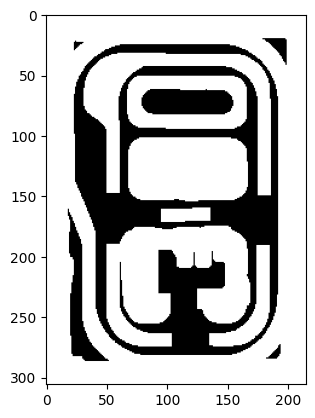

In [121]:
plt.imshow(weight_map, cmap='gray')

In [46]:
wp_path

[(189, 94),
 (178, 42),
 (107, 28),
 (37, 42),
 (44, 95),
 (44, 140),
 (73, 173),
 (155, 173),
 (171, 196),
 (142, 261),
 (88, 261),
 (58, 196),
 (85, 96),
 (64, 80)]

In [ ]:
s = first_wp_path[-2]

g = wp_path[-1]

s, g

path_result, _ = a_star((s[1], s[0]), (g[1], g[0]), waypoint_graph, grid=grid, weight_map=weight_map)



In [78]:
a = path_result

goal = (62, 98)

def expand_coordinates(coord, buffer_size):
    x, y = coord
    expanded_area = [(x + dx, y + dy) 
                     for dx in range(-buffer_size, buffer_size + 1) 
                     for dy in range(-buffer_size, buffer_size + 1)]
    return expanded_area

def expand_multiple_coordinates(coord_list, buffer_size):
    expanded_set = set()  # 중복 제거를 위해 set 사용
    for coord in coord_list:
        expanded_set.update(expand_coordinates(coord, buffer_size))
    return list(expanded_set)

expended_list = expand_multiple_coordinates(a, buffer_size=4)

expended_goal = expand_coordinates((goal[1], goal[0]), buffer_size=4)

if any(goal in expended_list for goal in expended_goal):
    print('yes')
else:
    print('no')


# check_list = []

# for i in range(len(expended_goal)):
#     if expended_goal[i] in expended_list:
#         check_list.append(1)
#     else:
#         check_list.append(0)

# if 1 in check_list:
#     print('yes')
# else:
#     print('no')

# if (goal[1], goal[0]) in expended_list:
#     print('yes')
# else:
#     print('no')

# yes 가 나오면 wp_path[-1] = goal 로 바꾸고
# no 가 나오면 wp_path.append(goal) 로 넣고 최종 path point 실행

yes


In [83]:
len(expended_goal)

81

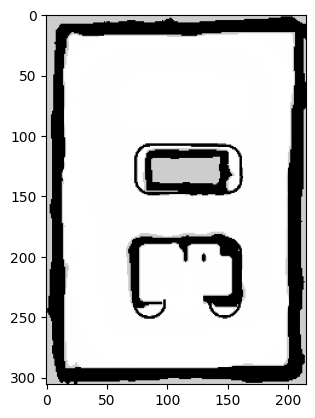

In [8]:
a = cv2.imread('/home/yoon/ws/open_cv/data/asap_map_resized_for_slam.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(a, cmap='gray')


### 2월 10일 수정본


너무 가깝지 않음
유효한 좌표
유효한 좌표
최소 비용 wp from start : 20번, 비용 : 26.0
두 번째로 작은 비용 wp from start : 17번, 비용 : 70.0
5번, 17번, 20번 예외처리
최소 비용 wp from goal : 23번, 비용 : 0
최소 비용 wp from goal : 0번, 비용 : 13.0
min1 선택 (goal)
new_start = (85, 96), new_goal = (121, 237)
waypoint 기반 전역 경로 pathplanning
처음 wp_path = [(85, 96), (150, 97), (170, 140), (171, 196), (142, 261), (121, 237)]
yessss
중간 1 경로: [(85, 96), (150, 97), (170, 140), (171, 196), (142, 261), (121, 237)]
--------------------------------------------------
중간 2 wp_path = [(85, 96), (150, 97), (170, 140), (171, 196), (142, 261), (121, 237)]
맨 처음 조건문
min1_take = None
wp_start = (62, 99), wp_goal = (150, 97)
최종 wp_path = [(85, 96), (150, 97), (170, 140), (171, 196), (142, 261), (121, 237)]
샘플링하기 전 real_path 갯수 = 91
1 번째 경로의 start : [99 62], goal : [ 97 150], wp_goal : (150, 97)
현재 두 wp 사이 지점 = [[ 99  62]
 [ 99  77]
 [ 99  92]
 [ 99 107]
 [ 99 122]
 [ 99 137]
 [ 97 150]], 갯수 = 7
현재 구간 real_path 갯수 7, x_path 갯수 7
---------------------------------------

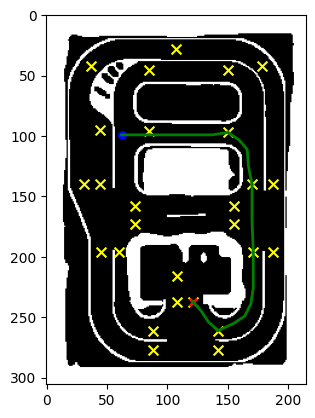

In [ ]:
import heapq
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
# from scipy.interpolate import interp1d
# from scipy.interpolate import splprep, splev

# 맵에서 상하좌우로 이동할 수 있는 방향을 나타내는 리스트
MOVES = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# pgm 지도를 이진화 형태로 변환
def pixel_based_map(img):
    img_height, img_width = img.shape  # 이미지 크기 가져오기

    # 결과 저장할 2D 리스트 생성 (기본값: 1 = 벽)
    map_cost = np.ones((img_height, img_width), dtype=int)

    # 모든 픽셀을 하나씩 순회하면서 계산
    for i in range(img_height):
        for j in range(img_width):
            if img[i, j] > 210:  # 밝은 픽셀(도로)
                map_cost[i, j] = 0  # 도로(0)
            else:  # 어두운 픽셀(벽)
                map_cost[i, j] = 1  # 벽(1)

    return map_cost

# 가장 적은 비용을 가진 두 wp 가져오기
def find_two_smallest(cost_list):
    min1, min2 = float('inf'), float('inf')  # 처음에는 무한대로 초기화

    for value in cost_list:
        if value < min1:
            min2 = min1  # 현재 min1이 두 번째로 작은 값이 됨
            min1 = value  # 새로운 최소값을 min1에 할당
        elif value < min2:  # min1보다 크고 min2보다 작은 값
            min2 = value  # 두 번째로 작은 값 업데이트

    return min1, min2, cost_list.index(min1), cost_list.index(min2)


# 장애물 근처에 가중치 맵 생성하기
def create_weight_map(grid, middle, buffer_size, penalty):
    background = grid  # 이진화 된 배열 형태의 전체 map
    overlay = middle  # 이진화 된 배열 형태의 중앙선 map

    # background[200:228, 86:89] = 1

    x, y = 18, 19  # 중앙선 map 을 삽입할 위치

    background_result = background.astype('uint8')
    overlay = overlay.astype('uint8')

    h, w = overlay.shape[:2]
    background_roi = background_result[y:y+h, x:x+w]

    result_roi = background_roi - overlay

    background_result[y:y+h, x:x+w] = result_roi

    plt.imshow(background_result, cmap='gray')
 
    obstacle = background_result == 1
    # 장애물 주변에 가중치를 부여
    dilated_obstacle = binary_dilation(obstacle, structure=np.ones((buffer_size, buffer_size)))
    weight_map = np.zeros_like(background_result, dtype=float)
    weight_map[dilated_obstacle] = penalty
    return weight_map, background_result

# 휴리스틱 함수 : 유클리드 거리 계산
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
    # return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def a_star(start, goal, waypoint_graph=None, grid=None, weight_map=None):
    # waypoint 기반 전역 경로 pathplanning
    if grid is None and weight_map is None:
        print('waypoint 기반 전역 경로 pathplanning')
        """ A* 알고리즘을 사용하여 start에서 goal까지 최단 경로 찾기 """
        open_set = []  # 우선순위 큐 (힙)
        heapq.heappush(open_set, (0, start))  # (f_score, node)
        
        came_from = {}  # 경로 추적을 위한 딕셔너리
        g_score = {node: float('inf') for node in waypoint_graph}  # 시작점에서의 거리
        g_score[start] = 0
        f_score = {node: float('inf') for node in waypoint_graph}  # 휴리스틱 거리 포함 점수
        f_score[start] = euclidean_distance(start, goal)
        
        while open_set:
            _, current = heapq.heappop(open_set)  # f_score가 가장 낮은 노드 선택
            
            if current == goal:
                # 최단 경로를 재구성하여 반환
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                return path[::-1]  # 역순으로 반환
            
            for neighbor in waypoint_graph[current]:
                tentative_g_score = g_score[current] + euclidean_distance(current, neighbor)
                
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + euclidean_distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        
        return None  # 경로가 없는 경우
    # 두 waypoint 사이 pathplanning
    else:
        open_set = []
        heapq.heappush(open_set, (0 + euclidean_distance(start, goal), 0, start))
        g_costs = {start: 0}

        came_from = {}

        while open_set:
            _, current_cost, current = heapq.heappop(open_set)

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()

                # goal까지의 총 비용 출력
                # print(f"Total cost from {start} to {goal}: {g_costs[goal]}")
                return path, g_costs[goal]
            
            for move in MOVES:
                neighbor = (current[0] + move[0], current[1] + move[1])
                if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                    tentative_g_cost = current_cost + 1 + weight_map[neighbor]  # 가중치 추가
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + euclidean_distance(neighbor, goal)
                        # f_cost = tentative_g_cost + manhattan_distance(neighbor, goal)
                        heapq.heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        came_from[neighbor] = current
        return None
    
    
def valid_start_goal(coord):
    if ((wp_num[33][0] < coord[0] < wp_num[33][1]) and (wp_num[34][0] < coord[1] < wp_num[34][1])) or ((wp_num[35][0] < coord[0] < wp_num[35][1]) and (wp_num[36][0] < coord[1] < wp_num[36][1])) or ((wp_num[37][0] < coord[0] < wp_num[37][1]) and (wp_num[38][0] < coord[1] < wp_num[38][1])):
        print('호출 및 주정차 금지 구역 입니다.')
        return False
    else:
        print('유효한 좌표')
        return True

def find_start_goal(coord, waypoint_graph, grid, weight_map, flag=None):
        global min1_take, min2_take, one_way, exc_sig, sig_2225, sig_1122
        cost_list = []
        for station in waypoint_graph:
            _, g_cost = a_star((coord[1], coord[0]), (station[1], station[0]), waypoint_graph, grid, weight_map)
            cost_list.append(g_cost)
        
        min1, min2, min1_idx, min2_idx = find_two_smallest(cost_list)

        # start 좌표를 줬을 때
        if flag is None:
            if (wp_num[30][0] < start[1] < wp_num[30][1] and wp_num[20][0] < start[0] < wp_num[22][0]):  # 일방 통행 구역에 start 가 있으면
                print('start 가 일방통행 구역 안에 있으므로 따로 처리')
                new_coord = wp_num[22]
                one_way = 1
                return new_coord
            elif (wp_num[31][0] < start[1] < wp_num[31][1] and wp_num[21][0] < start[0] < wp_num[25][0]):  # 다른 일방 통행 구역에 start 가 있으면
                print('start 가 일방통행 구역 안에 있으므로 따로 처리')
                new_coord = wp_num[25]
                one_way = 1
                return new_coord
            else:
                print(f"최소 비용 wp from start : {min1_idx}번, 비용 : {min1}")
                print(f"두 번째로 작은 비용 wp from start : {min2_idx}번, 비용 : {min2}")

        
                # if (min1_idx == 20 and min2_idx == 21 and start[1] < wp_num[32][0]) or (min1_idx == 22 and min2_idx == 25):   
                if (min1_idx == 20 and min2_idx == 21 and start[1] < wp_num[32][0]):
                    new_coord, idx = wp_num[min2_idx], min2_idx
                    min2_take = 1
                    print('min2 선택!(start)')
                    return new_coord
                else:
                    if (min1_idx == 20 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 20) or (min1_idx == 5 and min2_idx == 17) or (min1_idx == 17 and min2_idx == 5):
                        exc_sig = 1
                        new_coord = wp_num[20]
                        print('5번, 17번, 20번 예외처리')
                        return new_coord
                    else:
                        new_coord, idx = wp_num[min1_idx], min1_idx
                        min1_take = 1
                        print('min1 선택! (start)')
                        if (min1_idx == 22 or min1_idx == 25) and (min2_idx == 22 or min2_idx == 25):
                            sig_2225 = 1
                        elif (min1_idx in [11, 22]) and (min2_idx in [11, 22]):
                            sig_1122 = 1
                        return new_coord
        
        # goal 좌표를 줬을 때
        else:
            print(f"최소 비용 wp from goal : {min1_idx}번, 비용 : {min1}")
            print(f"최소 비용 wp from goal : {min2_idx}번, 비용 : {min2}")

            # if (min1_idx == 5 and min2_idx == 20) or (min1_idx == 20 and min2_idx == 21) or (min1_idx == 22 and min2_idx == 25 and goal[1] <= wp_num[30][0]):
            if (min1_idx == 5 and min2_idx == 20) or (min1_idx == 20 and min2_idx == 21):
                new_coord, idx = wp_num[min2_idx], min2_idx
                print('min2 선택 (goal)')
                return new_coord
            # elif (min1_idx == 22 and min2_idx == 25 and goal[1] <= wp_num[30][0]):
            # elif (min1_idx in [11, 22] and min2_idx in [11, 22]):
            #     print('wp[11]을 new_coord 로 선택')
            #     new_coord = wp_num[11]
            #     return new_coord
            elif (min1_idx in [11, 22] and min2_idx in [11, 22]):
                if goal[1] <= wp_num[24][1]:  # 95 이하면
                    print('wp[25]를 new_coord 로 선택')
                    new_coord = wp_num[25]
                    return new_coord
                else:
                    print('wp[11]을 new_coord 로 선택')
                    new_coord = wp_num[11]
                    return new_coord
            elif (min1_idx in [25, 22] and min2_idx in [25, 22]):
                print('wp[25]을 new_coord 로 선택')
                new_coord = wp_num[25]
                return new_coord
            else:
                new_coord, idx = wp_num[min1_idx], min1_idx
                print('min1 선택 (goal)')
                return new_coord
            
def expand_coordinates(coord, buffer_size):
    x, y = coord
    expanded_area = [(x + dx, y + dy) 
                     for dx in range(-buffer_size, buffer_size + 1) 
                     for dy in range(-buffer_size, buffer_size + 1)]
    return expanded_area

def expand_multiple_coordinates(coord_list, buffer_size):
    expanded_set = set()  # 중복 제거를 위해 set 사용
    for coord in coord_list:
        expanded_set.update(expand_coordinates(coord, buffer_size))
    return list(expanded_set)

# wp number
wp_num = {
    0 : (108, 237),
    1 : (88, 261),
    2 : (88, 277),
    3 : (60, 196),
    4 : (45, 196),
    5 : (44, 140),
    6 : (31, 140),
    7 : (37, 42),
    8 : (107, 28),
    9 : (178, 42),
    10 : (187, 140),
    11 : (170, 140),
    12 : (187, 196),
    13 : (171, 196),
    14 : (142, 277),
    15 : (142, 261),
    16 : (73, 173),
    17 : (73, 158),
    18 : (155, 173),
    19 : (155, 158),
    20 : (85,96),
    21 : (85, 45),
    22 : (150, 97),
    23 : (121, 237),
    24 : (44,95),
    25 : (150, 45),
    26 : (108, 216),
    # 일방 통행 좌표용
    30 : (88, 107),
    31 : (37, 56),

    # 조건문 좌표용
    32 : (90, 0),

    33 : (20, 73),
    34 : (133, 195),
    35 : (162, 196),
    36 : (142, 195),
    37 : (93, 139),
    38 : (243, 287)
}

# Waypoint 그래프
waypoint_graph = {
    wp_num[0]: [wp_num[1], wp_num[14]],  # 0번 : 1, 14
    wp_num[1]: [wp_num[3]],  # 1번 : 3
    wp_num[2]: [wp_num[14], wp_num[23]],  # 2번 : 14, 23
    wp_num[3]: [wp_num[16], wp_num[20], wp_num[21]],  # 3번 : 16, 20
    wp_num[4]: [wp_num[2]],  # 4번 : 2
    wp_num[5]: [wp_num[16]],  # 5번 : 16
    wp_num[6]: [wp_num[4]],  # 6번 : 4
    wp_num[7]: [wp_num[6], wp_num[24]],  # 7번 : 6, 24
    wp_num[8]: [wp_num[7]],  # 8번 : 7
    wp_num[9]: [wp_num[8]],  # 9번 : 8
    wp_num[10]: [wp_num[9]],  # 10번 : 9
    wp_num[11]: [wp_num[13], wp_num[19]],  # 11번 : 13, 19
    wp_num[12]: [wp_num[10], wp_num[19]],  # 12번 : 10, 19
    wp_num[13]: [wp_num[15]],  # 13번 : 15
    wp_num[14]: [wp_num[12]],  # 14번 : 12
    wp_num[15]: [wp_num[1], wp_num[23]],  # 15번 : 1, 23
    wp_num[16]: [wp_num[18]],  # 16번 : 18
    wp_num[17]: [wp_num[4], wp_num[20], wp_num[21]],  # 17번 : 4, 20, 21
    wp_num[18]: [wp_num[10], wp_num[13]],  # 18번 : 10, 13
    wp_num[19]: [wp_num[17]],  # 19번 : 17
    wp_num[20]: [wp_num[21], wp_num[22]],  # 20번 : 21, 22
    # wp_num[20]: [wp_num[22]],  # 20번 : 21, 22
    wp_num[21]: [wp_num[25]],  # 21번 : 25
    wp_num[22]: [wp_num[11]],  # 22번 : 11

    wp_num[23]: [],  # 23번 : 도착 시 행하는 명령어만 따로 만들기

    wp_num[24]: [wp_num[5], wp_num[6]],  # 24번 : 5, 6  
    wp_num[25]: [wp_num[11]], # 25번 : 11
    wp_num[26]: [wp_num[0]]  # 26번 : 0
}

# 주 지도
map = cv2.imread('/home/yoon/ws/ros-repo-3/src/Server/User_GUI/Images/asap_map_resized.pgm', cv2.COLOR_BGR2GRAY)
# print(f'map.shape = {map.shape}')

# 중앙선 지도 (이미 이진화 됨)
middle = cv2.imread('/home/yoon/ws/open_cv/data/asap_map_middleLine.png', cv2.IMREAD_GRAYSCALE)
# middle = cv2.cvtColor(middle, )
# print(f'middle.shape = {middle.shape}')

# 지도 변환 pgm -> 이진 배열 (0: 도로, 1: 장애물)
grid = pixel_based_map(map)
plt.imshow(grid, cmap='gray')

# Waypoints 시각화
for wp, _ in waypoint_graph.items():
    plt.scatter(wp[0], wp[1], color='yellow', marker='x', s=50)  # Waypoint

# 렌트 여부, 반납 여부
# GUI 로부터 받아야 하는 신호
is_renting = True
pp_cnt = False

# return_sig = False

# min1, min2 선택 여부
min1_take = None
min2_take = None

# 일방 통행 여부
one_way = None

# (5번, 20번), (5번, 17번) wp 사이 예외 처리 시그널
exc_sig = None

sig_2225 = None

# 테스트 실행 
start = (62, 99)  # 시작 좌표
# start = wp_num[21]  # 목표 좌표
goal = (62, 99)  # (53, 20) 에러 발생
if is_renting is False:
        goal = wp_num[23]  # 목표 좌표

expanded_start = expand_coordinates((start[1], start[0]), 4)
expanded_goal = expand_coordinates((goal[1], goal[0]), 4)

if set(expanded_start) & set(expanded_goal):
    print('너무 가까움')
    overlap = True  # 시작점과 도착점이 너무 가까움
else:
    print('너무 가깝지 않음')
    overlap = False

# 둘 다 True 면 실행되야 함.
start_valid = valid_start_goal(start)
goal_valid = valid_start_goal(goal)

if start_valid and goal_valid:
    # if is_renting is False:
    #     goal = wp_num[23]  # 목표 좌표

    # 장애물 주변 가중치 추가
    weight_map, background_result = create_weight_map(grid, middle, buffer_size=10, penalty=7)

    # 시작점, 출발점 보간
    if pp_cnt:
        new_start = find_start_goal(start, waypoint_graph, grid, weight_map)
        # new_start = wp_num[25]
    else:
        print('new_start = 26번 wp')
        new_start = wp_num[26]
    
    new_goal = find_start_goal(goal, waypoint_graph, grid, weight_map, flag=1)

    print(f"new_start = {new_start}, new_goal = {new_goal}")

    # 시작점, 목표점
    plt.scatter(start[0], start[1], color='blue', marker='o', label='Start', s=30)
    plt.scatter(goal[0], goal[1], color='red', marker='x', label='Goal', s=30)

    if (new_start != new_goal or exc_sig) and overlap == False:

        first_wp_path = a_star(new_start, new_goal, waypoint_graph)

        print(f'처음 wp_path = {first_wp_path}')

        # 도착점 구하기
        s = first_wp_path[-2]
        g = first_wp_path[-1]

        path_result, _ = a_star((s[1], s[0]), (g[1], g[0]), waypoint_graph, grid=grid, weight_map=weight_map)

        expended_list = expand_multiple_coordinates(path_result, buffer_size=10)

        expended_goal = expand_coordinates((goal[1], goal[0]), buffer_size=10)

        if any(goal in expended_list for goal in expended_goal):
            print('yessss')
            first_wp_path[-1] = goal
        else:
            print('noooo')
            first_wp_path.append(goal)
            
        wp_path = first_wp_path

        print("중간 1 경로:", wp_path)
        print('-' * 50)

        # 전역 경로 사이 두 waypoint 간의 pathplanning 실행
        if wp_path:
            linked_path = []
            if len(wp_path) == 1 or one_way:
                print('원래 start 좌표가 wp_path 맨 앞으로 들어옴')
                wp_path.insert(0, start)

            if one_way:
                for_cnt = len(wp_path) - 1
            else:
                for_cnt = len(wp_path)

            print(f'중간 2 wp_path = {wp_path}')

            real_wp_path = []

            for i in range(for_cnt):
                # start 좌표가 waypoint_graph 에 명시된 좌표가 아니면
                # 우선 현재 좌표에서 모든 wp 까지의 비용을 구한 후 가장 최소 비용을 가지는 wp 를 start 좌표로 고정
                if ((i == 0) and (wp_path[i] != start)):
                    if len(wp_path) == 1:
                        print('wp_path 값이 하나일 때')
                        wp_start = start
                        wp_goal = wp_path[i]
                    else:
                        print('맨 처음 조건문')
                        print(f"min1_take = {min1_take}")
                        # 최초 차고지로부터 호출 시 무조건 start = (89, 216) 부근
                        # if is_renting is False:  # 최초 한 번 호출 시
                        if pp_cnt is False:  # 최초 한번 호출 시 
                            if exc_sig:
                                print('5번, 20번 예외처리 시작 in for 문')
                                wp_path[0] = start
                                # pp_cnt = True
                            else:
                                # wp_path[0] = start
                                print('맨 앞에 start 삽입')
                                wp_path.insert(0, start)
 
                        else:  # pp_cnt is True
                            if (min1_take is None and min2_take):
                                print('맨 앞에 new_start 삽입')
                                wp_path.insert(0, new_start)  # 이게 min2_take 일 때
                                
                                print(f'이 후 wp_path = {wp_path}')

                            # elif (min2_take is None and min1_take == 1) or (call_sig is not None):
                            elif (min2_take is None and min1_take):
                                if (exc_sig or len(wp_path) <= 2):
                                    # wp_path.insert(0, start)
                                    print('지금!!!!!')
                                    if sig_2225 or sig_1122:
                                        wp_path[0] = start
                                    else:
                                        wp_path.insert(0, start)
                                else:
                                    print('일반적으로 min1_take = 1 일 때 맨 앞에 start 삽입')
                                    wp_path[0] = start
            
                        wp_start = start
                        wp_goal = wp_path[i + 1]
                        print(f'wp_start = {wp_start}, wp_goal = {wp_goal}')
                    
                    # print(f'최종 wp_path = {wp_path}')
                    
                else:
                    try:
                        print('마지막 조건문')
                        wp_start = wp_path[i]
                        wp_goal = wp_path[i + 1]
                    except:
                        pass
                
                print(f'최종 wp_path = {wp_path}')

                part_path, _ = (a_star((wp_start[1], wp_start[0]), (wp_goal[1], wp_goal[0]), waypoint_graph, grid=grid, weight_map=weight_map))
                real_path = np.array(part_path)

                print(f'샘플링하기 전 real_path 갯수 = {len(real_path)}')
                # print(f'real_path = {real_path}')

                sample_cnt = 15
                
                # 즉 , 샘플링 하고 나서 1개 이상 나와야 함.
                if len(real_path) // sample_cnt >= 1 and len(real_path) > sample_cnt:
                    real_path = real_path[::sample_cnt] 
                else:
                    pass

                # 경로 마지막 좌표가 waypoint 좌표가 아니면 waypoint 좌표로 맞춰주기
                if (len(wp_path) != 1) and (tuple(real_path[-1]) != (wp_goal[1], wp_goal[0])):
                    real_path[-1] = (wp_goal[1], wp_goal[0])
                    # real_path.append((wp_goal[1], wp_goal[0]))
                print(f"{i + 1} 번째 경로의 start : {(real_path[0])}, goal : {(real_path[-1])}, wp_goal : {wp_goal}")
                
                linked_path.append(real_path)

                real_wp_path.append(real_path[0])
                real_wp_path.append(real_path[-1])

                print(f'현재 두 wp 사이 지점 = {real_path}, 갯수 = {len(real_path)}')
                
                path_x = real_path[:, 0]
                path_y = real_path[:, 1]

                print(f"현재 구간 real_path 갯수 {len(real_path)}, x_path 갯수 {len(path_x)}")

                m = len(path_x)  # 데이터 개수
                k = (5, m - 1)  # 최소한 m > k 조건을 만족하도록 설정

                # b - spline 보간법
                try:
                    tck, u = splprep([path_x, path_y], s=5, k=k)  # s 가 클수록 부드러운 곡선
                    u_fine = np.linspace(0, 1, 300)  # 값이 클수록 세밀한 보간
                    smooth_x, smooth_y = splev(u_fine, tck)

                    plt.plot(smooth_y, smooth_x, 'green', linewidth=2, label='Path')
                except:
                    plt.plot(real_path[:, 1], real_path[:, 0], color='green', linewidth=2, label="Path")    
                print('-' * 50)
            linked_path = np.concatenate(linked_path)
            _, idx = np.unique(linked_path, axis=0, return_index=True)
            final_path = linked_path[np.sort(idx)]
        else:
            print('No path found')
    else:
        print('현재 목적지 근처에 있습니다.')


    # 시그널 초기화
    print('모든 시그널 초기화')
    # is_renting = return_sig = False
    min1_take = min2_take = one_way = exc_sig = for_cnt = sig_2225 = sig_1122 = None
else:
    print('호출 및 주정차 금지 구역입니다.')


print(f'start_valid = {start_valid}')
print(f'goal_valid = {goal_valid}')

In [211]:
final_path

array([[ 99,  62],
       [ 99,  77],
       [ 99,  92],
       [ 99, 107],
       [ 99, 122],
       [ 99, 137],
       [ 97, 150],
       [103, 159],
       [111, 166],
       [125, 167],
       [140, 170],
       [155, 170],
       [170, 170],
       [196, 171],
       [211, 171],
       [226, 171],
       [239, 169],
       [249, 164],
       [255, 155],
       [261, 142],
       [254, 134],
       [245, 128],
       [237, 121]])

In [151]:
start = (167, 80)  # 시작 좌표
# start = wp_num[21]  # 목표 좌표
goal = (169, 103)  

def expand_coordinates(coord, buffer_size):
    x, y = coord
    expanded_area = [(x + dx, y + dy) 
                     for dx in range(-buffer_size, buffer_size + 1) 
                     for dy in range(-buffer_size, buffer_size + 1)]
    return expanded_area

expanded_start = expand_coordinates((start[1], start[0]), 15)
expanded_goal = expand_coordinates((goal[1], goal[0]), 15)

print(len(expanded_start), len(expanded_goal))

961 961


In [152]:
expanded_start

[(65, 152),
 (65, 153),
 (65, 154),
 (65, 155),
 (65, 156),
 (65, 157),
 (65, 158),
 (65, 159),
 (65, 160),
 (65, 161),
 (65, 162),
 (65, 163),
 (65, 164),
 (65, 165),
 (65, 166),
 (65, 167),
 (65, 168),
 (65, 169),
 (65, 170),
 (65, 171),
 (65, 172),
 (65, 173),
 (65, 174),
 (65, 175),
 (65, 176),
 (65, 177),
 (65, 178),
 (65, 179),
 (65, 180),
 (65, 181),
 (65, 182),
 (66, 152),
 (66, 153),
 (66, 154),
 (66, 155),
 (66, 156),
 (66, 157),
 (66, 158),
 (66, 159),
 (66, 160),
 (66, 161),
 (66, 162),
 (66, 163),
 (66, 164),
 (66, 165),
 (66, 166),
 (66, 167),
 (66, 168),
 (66, 169),
 (66, 170),
 (66, 171),
 (66, 172),
 (66, 173),
 (66, 174),
 (66, 175),
 (66, 176),
 (66, 177),
 (66, 178),
 (66, 179),
 (66, 180),
 (66, 181),
 (66, 182),
 (67, 152),
 (67, 153),
 (67, 154),
 (67, 155),
 (67, 156),
 (67, 157),
 (67, 158),
 (67, 159),
 (67, 160),
 (67, 161),
 (67, 162),
 (67, 163),
 (67, 164),
 (67, 165),
 (67, 166),
 (67, 167),
 (67, 168),
 (67, 169),
 (67, 170),
 (67, 171),
 (67, 172),
 (67

In [153]:
expanded_goal

[(88, 154),
 (88, 155),
 (88, 156),
 (88, 157),
 (88, 158),
 (88, 159),
 (88, 160),
 (88, 161),
 (88, 162),
 (88, 163),
 (88, 164),
 (88, 165),
 (88, 166),
 (88, 167),
 (88, 168),
 (88, 169),
 (88, 170),
 (88, 171),
 (88, 172),
 (88, 173),
 (88, 174),
 (88, 175),
 (88, 176),
 (88, 177),
 (88, 178),
 (88, 179),
 (88, 180),
 (88, 181),
 (88, 182),
 (88, 183),
 (88, 184),
 (89, 154),
 (89, 155),
 (89, 156),
 (89, 157),
 (89, 158),
 (89, 159),
 (89, 160),
 (89, 161),
 (89, 162),
 (89, 163),
 (89, 164),
 (89, 165),
 (89, 166),
 (89, 167),
 (89, 168),
 (89, 169),
 (89, 170),
 (89, 171),
 (89, 172),
 (89, 173),
 (89, 174),
 (89, 175),
 (89, 176),
 (89, 177),
 (89, 178),
 (89, 179),
 (89, 180),
 (89, 181),
 (89, 182),
 (89, 183),
 (89, 184),
 (90, 154),
 (90, 155),
 (90, 156),
 (90, 157),
 (90, 158),
 (90, 159),
 (90, 160),
 (90, 161),
 (90, 162),
 (90, 163),
 (90, 164),
 (90, 165),
 (90, 166),
 (90, 167),
 (90, 168),
 (90, 169),
 (90, 170),
 (90, 171),
 (90, 172),
 (90, 173),
 (90, 174),
 (90

In [154]:
if set(expanded_start) & set(expanded_goal):
    print('yes')
else:
    print('no')

yes


In [8]:
coord = (62, 64)

cost_list = []

for station in waypoint_graph:
    _, g_cost = a_star((coord[1], coord[0]), (station[1], station[0]), waypoint_graph, grid, weight_map)
    cost_list.append(g_cost)

cost_list

[np.float64(321.0),
 np.float64(309.0),
 np.float64(265.0),
 np.float64(183.0),
 np.float64(149.0),
 np.float64(110.0),
 np.float64(123.0),
 np.float64(182.0),
 np.float64(151.0),
 np.float64(228.0),
 np.float64(221.0),
 np.float64(184.0),
 np.float64(257.0),
 np.float64(241.0),
 np.float64(319.0),
 np.float64(331.0),
 np.float64(120.0),
 np.float64(105.0),
 np.float64(202.0),
 np.float64(187.0),
 np.float64(55.0),
 np.float64(42.0),
 np.float64(121.0),
 np.float64(334.0),
 np.float64(126.0),
 np.float64(107.0),
 np.float64(342.0)]

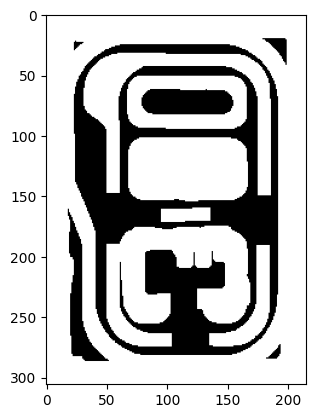

In [274]:
plt.imshow(weight_map, cmap='gray')

In [228]:
# len(linked_path)
final_path

array([[128, 169],
       [143, 169],
       [158, 155],
       [158, 140],
       [158, 125],
       [158, 110],
       [158,  95],
       [158,  73],
       [147,  69],
       [134,  67],
       [119,  67],
       [106,  69],
       [ 96,  85],
       [ 99, 103]])

In [141]:
a = np.concatenate(linked_path)

_, idx = np.unique(a, axis=0, return_index=True)

unique_arr = a[np.sort(idx)]

print(a)
print(unique_arr)

[[128  64]
 [113  64]
 [ 98  64]
 [ 83  64]
 [ 68  64]
 [ 57  68]
 [ 46  85]
 [ 46  85]
 [ 46 100]
 [ 46 115]
 [ 48 132]
 [ 48 132]]
[[128  64]
 [113  64]
 [ 98  64]
 [ 83  64]
 [ 68  64]
 [ 57  68]
 [ 46  85]
 [ 46 100]
 [ 46 115]
 [ 48 132]]
